# apply instruments settings

In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config_custom as hdc

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE, TaskMode
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
from nidaqmx.stream_readers import AnalogSingleChannelReader, DigitalSingleChannelReader

import numpy as np

In [2]:
# connect to devices
pg  = PulseGenerator(ip=hdc.PS_IP, chmap=hdc.PS_chmap) 
mwsyn = Synthesizer(hdc.VDISYN_SN, 
                    vidpid=hdc.VDISYN_VIDPID,
                    baudrate=hdc.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hdc.LASER_SN)
laser.open()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


# Set parameters

In [177]:
current_percent = 99.09
# current_percent = 0.051
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [178]:
f_NVguess = 392.83677300810814
# f_NVguess = 398.5607725381851
freq_start = (f_NVguess-0.020)/24.0
freq_stop = (f_NVguess+0.020)/24.0
step_min = mwsyn.get_min_step_size([freq_start], [freq_stop])[0] # in Hz
freq_step = 0.5E-3/24.0
freq_step = int(freq_step/step_min*1E9)*step_min/1E9
step_rise = freq_step
step_fall = freq_step
steptime = 4.0E3 # [ns]
steptime = int(steptime/4)*4
steptime_rise = steptime 
steptime_fall = steptime
dwellatlow = False
dwellathigh = False
num_risesweep = int((freq_stop-freq_start)/step_rise)+1
num_fallsweep = int((freq_stop-freq_start)/step_fall)+1
print(f"Approximated Time to Sweep along rise direction: \n{(freq_stop-freq_start)/step_rise*steptime_rise/1E6}ms")

actualpara = mwsyn.sweep(freq_start, freq_stop, 
                         step_rise, step_fall, 
                         steptime_rise, steptime_fall, 
                         dwellatlow, dwellathigh)
(freq_start_actual, freq_stop_actual, step_rise_actual, step_fall_actual) = actualpara
freq_actual_rise = 24.0*np.arange(freq_start_actual, freq_stop_actual+step_rise_actual, step_rise_actual)
freq_actual_fall = 24.0*np.flip(np.arange(freq_start_actual+step_rise_actual, freq_stop_actual, step_fall_actual))
freq_sawsweep = np.append(freq_actual_rise, freq_actual_fall)
num_freqsaw = len(freq_sawsweep)

# start frequency sweep
mwsyn.reset_trigger()
mwsyn.sweep_continue()
# time.sleep(5) #sweep for 5s
# mwsyn.sweep_pause()

Approximated Time to Sweep along rise direction: 
0.320023195040243ms


b'U'

In [179]:
seq_repeat = 8
clock_rate = 2/steptime #[GHz]
# dur_pt = (freq_stop-freq_start)*(steptime_rise/step_rise+steptime_fall/step_fall) +steptime_rise + steptime_fall# [ns]

time_fullsweep = steptime*num_freqsaw
daqtrig_delay = 512
seq_daqtrig = [(daqtrig_delay, LOW), (time_fullsweep/2.0, HIGH), (time_fullsweep/2.0-daqtrig_delay, LOW)]
# seq_laser = [(time_fullsweep, HIGH)]
# seq_mwA = [(time_fullsweep, HIGH)]
seq_laser = [(steptime/2.0, HIGH), (steptime/2.0, HIGH)]*num_freqsaw
seq_mwA = [(steptime/2.0, HIGH), (steptime/2.0, LOW)]*num_freqsaw
seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*num_freqsaw*2


pg.setDigital("laser", seq_laser*seq_repeat)
pg.setDigital("mw_A", seq_mwA*seq_repeat)
# pg.setDigital("laser", seq_mwA)
# pg.setDigital("mw_A", seq_laser)
pg.setDigital("daqtrig", seq_daqtrig*seq_repeat)
pg.setDigital("clock", seq_clock*seq_repeat)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)

In [201]:
# signal reading parameters
min_volt = -0.005 # [V]
max_volt = 0.03
samplerate_read = clock_rate*1E9 # 500kHz .max ext clock rate of NI6343
basetime = 1.0/samplerate_read
# num_readsample = int(samplerate_read*dur_pt/1E9)
# assert num_readsample == len(freq_sawsweep)
num_readsample = 2*num_freqsaw
timeout_read = max(time_fullsweep*2.0/1E9, 10)
buffer_readpoint = np.zeros(num_readsample, dtype=np.float64, order='C')

# Create tasks for the analog and digital inputs
analog_task = nidaqmx.Task("Read FL")
digital_task = nidaqmx.Task("Read VDI Synth Trigger Out")
DAQch_VDISynTrigOut = "/Dev1/port0/line7"

# Add a single analog input channel (e.g., "Dev1/ai0")
analog_task.ai_channels.add_ai_voltage_chan(
    hdc.DAQch_APD,"",
    # TerminalConfiguration.RSE,
    TerminalConfiguration.DIFF,
    min_volt,max_volt,
    VoltageUnits.VOLTS
)

# Add a single digital input channel (e.g., "Dev1/port0/line0")
digital_task.di_channels.add_di_chan(DAQch_VDISynTrigOut)

# Configure both tasks to be triggered by a common TTL source (e.g., "Dev1/PFI0")
analog_task.triggers.start_trigger.cfg_dig_edge_start_trig(
    hdc.DAQch_Trig, Edge.RISING
)
digital_task.triggers.start_trigger.cfg_dig_edge_start_trig(
    hdc.DAQch_Trig, Edge.RISING
)

# Configure continuous acquisition for both tasks
sample_rate = samplerate_read  # samples per second
analog_task.timing.cfg_samp_clk_timing(
    rate=sample_rate,
    source=hdc.DAQch_Clock,
    sample_mode=AcquisitionType.CONTINUOUS,
    samps_per_chan = num_readsample
)
digital_task.timing.cfg_samp_clk_timing(
    rate=sample_rate,
    source=hdc.DAQch_Clock,
    sample_mode=AcquisitionType.CONTINUOUS,
    samps_per_chan = num_readsample
)

# Pre-commit the tasks for faster start
analog_task.control(TaskMode.TASK_COMMIT)
digital_task.control(TaskMode.TASK_COMMIT)

# Initialize readers for continuous streaming
analog_reader = AnalogSingleChannelReader(analog_task.in_stream)
digital_reader = DigitalSingleChannelReader(digital_task.in_stream)

# Read smaller samples for real-time feedback
analog_data = np.zeros(num_readsample, dtype=np.float64, order='C')  # Buffer for analog data
digital_data = np.zeros(num_readsample, dtype=np.uint32, order='C')  # Buffer for digital data
# # NIDAQ can handle the buffer allocation automatically
# buf_size = int(samples_per_read*1000)
# analog_task.in_stream.input_buf_size = buf_size
# digital_task.in_stream.input_buf_size = buf_size


In [200]:
analog_task.close()
digital_task.close()

# Start measurement


In [183]:
laser.laser_on() # turn off laser

In [71]:
def shift(arr, idx):
    result = np.empty_like(arr)
    arrlen = len(arr)
    result[arrlen-idx:arrlen] = arr[:idx]
    result[:(arrlen-idx)] = arr[(idx-arrlen):]
    return result

In [72]:
# functions for fitting =============================
def lorentzian_bg(x, A, x0, gamma, B):
    # lorentzian with background floor
    return 0.5*A*gamma/np.pi/(np.square(x-x0)+np.square(0.5*gamma)) + B

def lorentzian_bg_estimator(xdata, ydata):
    idxmax = np.argmax(ydata)
    idxmin = np.argmin(ydata)
    ymin = np.min(ydata)
    ymax = np.max(ydata)
    # ydata = (ydata-ymin)/(ymax-ymin)
    baseline = np.median(ydata)
    # baseline = np.square(np.median(np.sqrt(ydata)))
    pospeak = (ymax-baseline)>(baseline-ymin)
    A = (ymax-baseline)*pospeak + (ymin-baseline)*(not pospeak)
    idxpeak = idxmax*pospeak + idxmin*(not pospeak)
    x0 = xdata[idxpeak]
    idxhalf = np.argmin(np.absolute(ydata-A/2))
    gamma = abs(xdata[idxhalf]-xdata[idxpeak])
    return A, x0, gamma, baseline

def lorentzian_estimator(xdata, ydata):
    return lorentzian_bg_estimator(xdata, ydata)[:-1]

In [26]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(lorentzian_bg, freq, contrast_av)

ModuleNotFoundError: No module named 'scipy'

In [202]:
daqtrig_delay_array = np.arange(0.0, 64, 64)
num_dtdely = len(daqtrig_delay_array)
contrast_dtd = np.zeros((num_dtdely, int(num_freqsaw/2)))
sig_dtd = np.zeros((num_dtdely, int(num_freqsaw/2)))
bg_dtd = np.zeros((num_dtdely, int(num_freqsaw/2)))
all_digital = []
contrastsingle_delay = np.zeros(num_dtdely)
for (ii, daqtrig_delay) in enumerate(daqtrig_delay_array):
    seq_daqtrig = [(daqtrig_delay, LOW), (time_fullsweep/2.0, HIGH), (time_fullsweep/2.0-daqtrig_delay, LOW)]
    pg.setDigital("daqtrig", seq_daqtrig*seq_repeat)
    pg.stream(n_runs=INF)
    pg.startNow()

    # Start the tasks
    analog_task.start()
    digital_task.start()
    # Read data for a specific duration
    analog_data_av = np.zeros(num_readsample, dtype=np.float64, order='C')  # Buffer for analog data
    digital_data_av = np.zeros(num_readsample, dtype=np.uint32, order='C')  # Buffer for digital data
    read_duration =  5  # read data for 5 seconds
    start_time = time.time()
    num_repeat = 0
    while time.time() - start_time < read_duration:
        # Read analog and digital data
        digital_reader.read_many_sample_port_uint32(
            digital_data, 
            number_of_samples_per_channel=num_readsample
        )
        analog_reader.read_many_sample(
            analog_data, 
            number_of_samples_per_channel=num_readsample
        )
        analog_data_av += np.copy(analog_data) 
        digital_data_av += np.copy(digital_data)  
        all_digital.append(np.copy(digital_data) )
        # Print or process the data
        # print("Analog Data:", analog_data)
        # print("Digital Data:", digital_data)
        num_repeat += 1
        # # Small delay to avoid excessive output
        # time.sleep(0.5)

    # Stop the tasks
    analog_task.stop()
    digital_task.stop()

    print(f"measurement repeat : {num_repeat} times")
    analog_data_av = analog_data_av/num_repeat
    digital_data_av = digital_data_av/num_repeat


    idx_step = np.argmax(np.diff(all_digital[0]))
    sigbg = shift(analog_data_av, idx_step)
    outtrig = shift(digital_data_av, idx_step)

    pl_rise = sigbg[:2*num_risesweep]
    pl_fall = np.flip(sigbg[2*num_fallsweep:])
    pl_av = (pl_rise + pl_fall)/2.0

    freq = freq_sawsweep[:num_risesweep]
    signal = sigbg[::2]
    sig_rise = signal[:num_risesweep]
    sig_fall = np.flip(signal[num_fallsweep:])
    sig_av = (sig_rise + sig_fall)/2.0
    backgroud = sigbg[1::2]
    bg_rise = backgroud[:num_risesweep]
    bg_fall = np.flip(backgroud[num_fallsweep:])
    bg_av = (bg_rise + bg_fall)/2.0

    contrast_mwrise = (sig_rise-bg_rise)/bg_rise
    contrast_mwfall = (sig_fall-bg_fall)/sig_fall

    
    contrast_av = (sig_av-bg_av)/bg_av
    sig_dtd[ii] = sig_av
    bg_dtd[ii] = bg_av
    contrast_dtd[ii] = contrast_av
    pkidx = np.argmax(np.square(contrast_av))
    contrastsingle_delay[ii] = contrast_av[pkidx]


measurement repeat : 7685 times


In [121]:
analog_task.stop()
digital_task.stop()

In [204]:
idx_step = np.argmin(np.abs(digital_data_av-64))
sigbg = shift(analog_data_av, idx_step)
outtrig = shift(digital_data_av, idx_step)

pl_rise = sigbg[:2*num_risesweep]
pl_fall = np.flip(sigbg[2*num_fallsweep:])
pl_av = (pl_rise + pl_fall)/2.0

freq = freq_sawsweep[:num_risesweep]
signal = sigbg[::2]
sig_rise = signal[:num_risesweep]
sig_fall = np.flip(signal[num_fallsweep:])
sig_av = (sig_rise + sig_fall)/2.0
backgroud = sigbg[1::2]
bg_rise = backgroud[:num_risesweep]
bg_fall = np.flip(backgroud[num_fallsweep:])
bg_av = (bg_rise + bg_fall)/2.0

contrast_mwrise = (sig_rise-bg_rise)/bg_rise
contrast_mwfall = (sig_fall-bg_fall)/sig_fall


contrast_av = (sig_av-bg_av)/bg_av
sig_dtd[ii] = sig_av
bg_dtd[ii] = bg_av
contrast_dtd[ii] = contrast_av
pkidx = np.argmax(np.square(contrast_av))
contrastsingle_delay[ii] = contrast_av[pkidx]


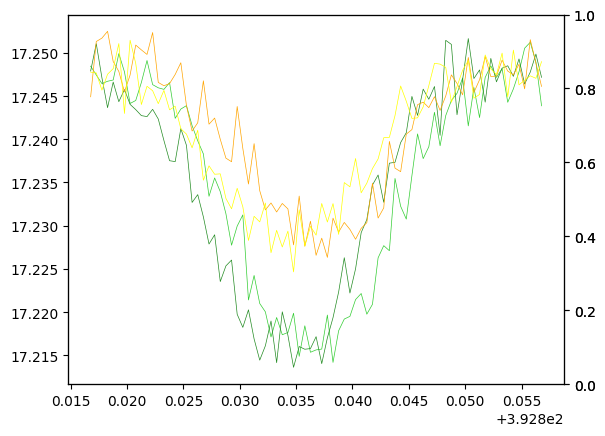

In [205]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
# ax1.plot(analog_data_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax2.plot(digital_data_av, linewidth=0.5, label="signal", color="green")
# ax1.plot(sigbg*1E3, linewidth=0.5, label="signal", color="red")
# ax3.plot(outtrig, linewidth=0.5, label="signal", color="blue")
ax1.plot(freq, sig_rise*1E3, linewidth=0.5, label="Signal (MW rise)", color="limegreen")
ax1.plot(freq, sig_fall*1E3, linewidth=0.5, label="Signal (MW fall)", color="forestgreen")
ax1.plot(freq, bg_rise*1E3, linewidth=0.5, label="Background (MW rise)", color="orange")
ax1.plot(freq, bg_fall*1E3, linewidth=0.5, label="Background (MW fall)", color="yellow")
# ax2.plot(freq, contrast_mwrise*100.0, linewidth=1, label="contrast (MW rise)", color='royalblue')
# ax2.plot(freq, contrast_mwfall*100.0, linewidth=1, label="contrast (MW fall)", color='cornflowerblue')
# idx_step = np.argmax(np.diff(all_digital[0]))+1
# for ddd in all_digital:
#     ax3.plot(ddd[idx_step-20:idx_step+10], linewidth=0.5, marker="*", label="signal")

# ax1.set_xlabel("Frequency [GHz]")
# ax1.set_ylabel("PL [mV]")
# ax2.set_ylabel("Contrast [%]", color='royalblue')
# ax1.legend(loc='lower left')
# plt.title("ODMR (ms=0 to -1)")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


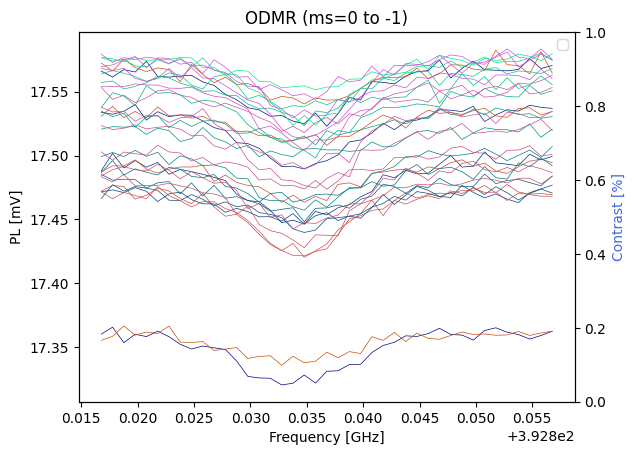

In [80]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# ax1.plot(freq, sig_rise*1E3, linewidth=0.5, label="Signal (MW rise)", color="limegreen")
# ax1.plot(freq, sig_fall*1E3, linewidth=0.5, label="Signal (MW fall)", color="forestgreen")
# ax1.plot(freq, bg_rise*1E3, linewidth=0.5, label="Background (MW rise)", color="orange")
# ax1.plot(freq, bg_fall*1E3, linewidth=0.5, label="Background (MW fall)", color="yellow")
for (ii, dtd) in enumerate(daqtrig_delay_array):
    ax1.plot(freq, sig_dtd[ii]*1E3, linewidth=0.5, label=f"daq trig delay {dtd} ns", color=(0,ii/num_dtdely,0.5))
    ax1.plot(freq, bg_dtd[ii]*1E3, linewidth=0.5, label=f"daq trig delay {dtd} ns", color=(0.8,0.3,ii/num_dtdely))
    # ax2.plot(freq, contrast_dtd[ii]*100.0, linewidth=1, label=f"daq trig delay {dtd} ns", color=(ii/num_dtdely,0.3,0.5))
ax1.set_xlabel("Frequency [GHz]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
# ax1.legend(loc='lower left')
ax2.legend(loc='upper right')
plt.title("ODMR (ms=0 to -1)")
plt.show()

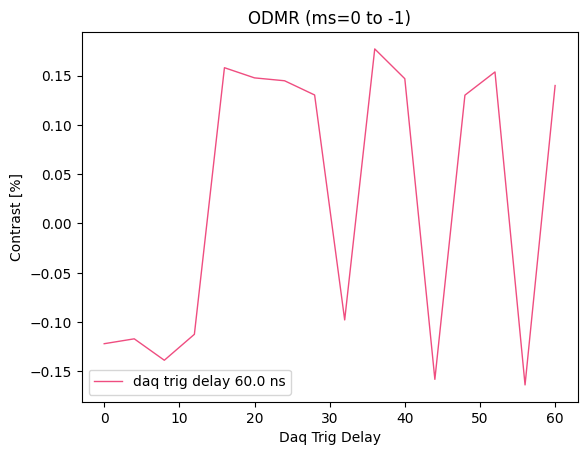

In [78]:
fig, ax1 = plt.subplots()
ax1.plot(daqtrig_delay_array, contrastsingle_delay*100.0, linewidth=1, label=f"daq trig delay {dtd} ns", color=(ii/num_dtdely,0.3,0.5))
ax1.set_xlabel("Daq Trig Delay")
ax1.set_ylabel("Contrast [%]")
ax1.legend(loc='lower left')
plt.title("ODMR (ms=0 to -1)")
plt.show()

In [206]:
analog_task.close()
digital_task.close()

In [37]:
np.savetxt('output\\NVp1_zoom(freq_signal_background)_20240429.txt', np.c_[freq_actual*24, signal_av, background_av])

In [64]:
mwsyn.reboot()

MW Synthesizer Rebooted!


In [207]:
pg.constant(OutputState.ZERO())
laser.laser_off() # turn off laser
# readtask.close()

In [208]:
mwsyn.close()

In [128]:
laser.close()

In [158]:
mwsyn.reboot()

MW Synthesizer Rebooted!


In [28]:
# close the communication
laser.close()
mwsyn.close()
pg.reset()